In [39]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn

In [40]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "fashion-mnist_train.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zalando-research/fashionmnist",
  file_path,
)

/tmp/ipython-input-1251482784.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'fashionmnist' dataset.


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, shuffle=True, random_state=42)

xtrain = xtrain/255
xtest = xtest/255

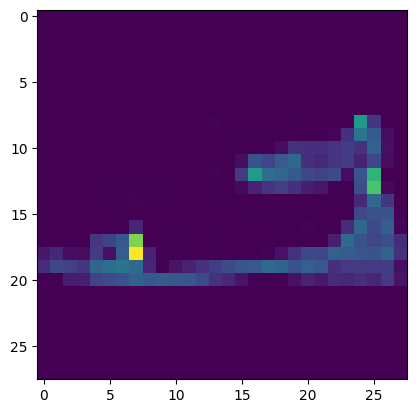

In [43]:
plt.imshow(xtrain.iloc[9, :].values.reshape(28,28))

In [44]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [45]:
class mnistANN(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 10),
            # nn.Softmax() no need to write as nn.CrossEntropyLoss will apply softmax and then calculate neg log likelihood loss
        )

    def forward(self, features):
        return self.network(features)

In [46]:
xtrain_tensor = torch.from_numpy(xtrain.values).float()
xtest_tensor = torch.from_numpy(xtest.values).float()
ytrain_tensor = torch.from_numpy(ytrain.values).float()
ytest_tensor = torch.from_numpy(ytest.values).float()

In [47]:
traindataset = CustomDataset(xtrain_tensor, ytrain_tensor)

In [48]:
traindataloader = DataLoader(traindataset, batch_size=100, shuffle=True)

In [49]:
learning_rate = 0.1
epochs = 100

model = mnistANN(num_features=xtrain.shape[1])

model.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(epochs):

    epoch_loss = 0

    for batch_features, batch_labels in traindataloader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        ypred = model(batch_features)

        loss = loss_function(ypred, batch_labels.long())

        epoch_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    print(f'epoch {epoch+1} -> loss {loss/(xtrain_tensor.shape[1]/100)}')

epoch 1 -> loss 0.04618438333272934
epoch 2 -> loss 0.05509559437632561
epoch 3 -> loss 0.05436084046959877
epoch 4 -> loss 0.03850662335753441
epoch 5 -> loss 0.049077559262514114
epoch 6 -> loss 0.06476671993732452
epoch 7 -> loss 0.07210473716259003
epoch 8 -> loss 0.03654802218079567
epoch 9 -> loss 0.04384569451212883
epoch 10 -> loss 0.05224733427166939
epoch 11 -> loss 0.03831133246421814
epoch 12 -> loss 0.028983233496546745
epoch 13 -> loss 0.052748631685972214
epoch 14 -> loss 0.028324292972683907
epoch 15 -> loss 0.033873505890369415
epoch 16 -> loss 0.05389976501464844
epoch 17 -> loss 0.06720921397209167
epoch 18 -> loss 0.04623749107122421
epoch 19 -> loss 0.019436746835708618
epoch 20 -> loss 0.04453573375940323
epoch 21 -> loss 0.03341488167643547
epoch 22 -> loss 0.03224269673228264
epoch 23 -> loss 0.03216414153575897
epoch 24 -> loss 0.05460524186491966
epoch 25 -> loss 0.04896705225110054
epoch 26 -> loss 0.03865231201052666
epoch 27 -> loss 0.022542309015989304
epo

In [50]:
model.eval() # helpful because certain part of NN, work differently during traing and prediction, like dropouts and batchnormalization

with torch.no_grad():
    xtest_tensor, ytest_tensor = xtest_tensor.to(device), ytest_tensor.to(device)
    ytest_pred = model(xtest_tensor)
    ytest_pred = ytest_pred.argmax(dim=1)

    ytrain_pred = model(xtrain_tensor.to(device))
    ytrain_pred = ytrain_pred.argmax(dim=1)

    print(classification_report(ytest_tensor.cpu(), ytest_pred.cpu()))

    print('*'*50)

    print(classification_report(ytrain_tensor.cpu(), ytrain_pred.cpu()))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      1519
         1.0       0.99      0.97      0.98      1479
         2.0       0.85      0.79      0.82      1494
         3.0       0.90      0.89      0.89      1541
         4.0       0.79      0.84      0.82      1483
         5.0       0.96      0.96      0.96      1435
         6.0       0.73      0.69      0.71      1561
         7.0       0.94      0.96      0.95      1541
         8.0       0.97      0.97      0.97      1447
         9.0       0.97      0.96      0.97      1500

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

**************************************************
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      4481
         1.0       1.00      1.00      1.00      4521
         2.0       0.96    